# VAE Tutorial: Learning to Generate Data with Variational Autoencoders

## What You'll Learn
- What are Variational Autoencoders (VAEs) and why they're powerful
- How the Encoder and Decoder work together to learn data representations
- How to implement a VAE model from scratch
- How to train the model and visualize the results

## What is a VAE?
A Variational Autoencoder (VAE) is a type of generative model that learns to:
- **Encode**: Compress data into a lower-dimensional latent space
- **Decode**: Reconstruct data from the latent representation
- **Generate**: Create new data by sampling from the learned latent space

Think of it like learning to compress and decompress data while understanding its underlying structure!

## The VAE Approach
VAEs use a probabilistic approach where:
- The encoder learns a distribution over latent variables
- The decoder learns to reconstruct data from latent samples
- The loss function balances reconstruction quality with latent space regularization

Let's dive in! 🚀


In [1]:
# PyTorch for deep learning
import torch
from torch import nn, optim
from torch.nn import functional as F

# For data visualization
import matplotlib.pyplot as plt
from pylab import rcParams

# For generating our dataset
from sklearn import datasets
import numpy as np

# For file operations
import os

# Set up plotting parameters
rcParams['figure.figsize'] = 8, 8
plt.ion()  # Interactive plotting

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


All libraries imported successfully!
PyTorch version: 2.9.0+cu126
Using device: CUDA


## Step 2: Configuration and Setup

Let's set up our hyperparameters (settings that control how our model learns). These are like the "knobs" we can turn to adjust our model's behavior.


In [2]:
# Training configuration
BATCH_SIZE = 256       # Increased batch size for better training stability
EPOCHS = 200          # More epochs for better convergence
LOG_INTERVAL = 50     # How often to print progress updates

# Model architecture
INPUT_DIM = 2          # Our data has 2 dimensions (x, y coordinates)
LATENT_DIM = 16         # Increased latent dimension for better representation
HIDDEN_DIM = 512       # Larger hidden layers for better capacity

# VAE-specific hyperparameters
LR = 5e-4             # Lower learning rate for more stable training
BETA = 0.5            # Reduced beta to prevent posterior collapse
BETA_WARMUP = 50      # Epochs to gradually increase beta
WEIGHT_DECAY = 1e-5   # L2 regularization

# Visualization settings
SAVE_PLT_INTERVAL = 10  # How often to save plots (every 10 epochs)

# Set up device (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("  Configuration set up!")
print(f"   Batch size: {BATCH_SIZE} (increased for stability)")
print(f"   Epochs: {EPOCHS} (more epochs for convergence)")
print(f"   Hidden dimension: {HIDDEN_DIM} (larger capacity)")
print(f"   Latent dimension: {LATENT_DIM} (increased for better representation)")
print(f"   Learning rate: {LR} (lower for stability)")
print(f"   Beta (KL weight): {BETA} (reduced to prevent collapse)")
print(f"   Beta warmup epochs: {BETA_WARMUP}")
print(f"   Weight decay: {WEIGHT_DECAY}")
print(f"   Device: {device}")

  Configuration set up!
   Batch size: 256 (increased for stability)
   Epochs: 200 (more epochs for convergence)
   Hidden dimension: 512 (larger capacity)
   Latent dimension: 16 (increased for better representation)
   Learning rate: 0.0005 (lower for stability)
   Beta (KL weight): 0.5 (reduced to prevent collapse)
   Beta warmup epochs: 50
   Weight decay: 1e-05
   Device: cuda


## Step 3: Create Our Dataset

We'll use the same "two moons" dataset as the other tutorials - it looks like two crescent moons! This is a great example because:
- It's simple to visualize (2D)
- It has a complex, non-linear shape
- It's perfect for testing generative models

Let's generate and visualize our data:


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

IMG_SHAPE = (1, 28, 28)
IMG_DIM = 28 * 28

DATASET_NAME = "mnist"
BATCH_SIZE = 256

transform = transforms.ToTensor()  # outputs in [0,1]

In [24]:
def get_dataloaders(name="mnist", batch_size=256, val_ratio=0.1):
    name = name.lower()
    ds_train = datasets.MNIST("./data", train=True, download=True, transform=transform)
    ds_test  = datasets.MNIST("./data", train=False, download=True, transform=transform)

    n_val = int(len(ds_train) * val_ratio)
    n_tr  = len(ds_train) - n_val
    ds_tr, ds_val = random_split(ds_train, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

    tr_loader  = DataLoader(ds_tr,  batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    te_loader  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return tr_loader, val_loader, te_loader

## Step 4: Prepare Data Loaders

Data loaders help us feed data to our model in small batches during training. This is more memory-efficient than loading all data at once.


In [5]:
# Set up data loaders for efficient batch processing
print("Setting up data loaders...")

train_loader, val_loader, test_loader = get_dataloaders(DATASET_NAME, BATCH_SIZE)

x0, _ = next(iter(train_loader))
print("Batch:", x0.shape, "range:", float(x0.min()), float(x0.max()))

print(f"Data loaders created!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Target device: {device}")

Setting up data loaders...


100%|██████████| 9.91M/9.91M [00:00<00:00, 43.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


Batch: torch.Size([256, 1, 28, 28]) range: 0.0 1.0
Data loaders created!
   Training batches: 211
   Test batches: 40
   Batch size: 256
   Target device: cuda


## Step 5: Understanding the VAE Architecture

Now let's build our VAE model! The key idea is to have two neural networks working together:

### What is an Encoder?
The **Encoder** takes data as input and compresses it into a lower-dimensional latent space. It learns to represent data in a compact form while preserving important information.

### What is a Decoder?
The **Decoder** takes latent representations and reconstructs the original data. It learns to "decompress" the latent space back into the original data space.

### The VAE Approach
- Encoder learns a distribution over latent variables (mean and variance)
- Decoder learns to reconstruct data from latent samples
- The loss function balances reconstruction quality with latent space regularization

Let's build them step by step:


Implement a VAE for both MNIST Digits and Fashion-MNIST datasets

In [6]:
class VAE(nn.Module):
    def __init__(self, z_dim=16):
        super().__init__()
        self.z_dim = z_dim

        # Encoder: 1x28x28 -> 64x7x7
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 7x7
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.mu = nn.Linear(256, z_dim)
        self.logvar = nn.Linear(256, z_dim)

        # Decoder: z -> 64x7x7 -> 1x28x28
        self.dec_fc1 = nn.Linear(z_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 28x28 (logits)
        )

    def encode(self, x):
        h = self.enc(x).view(x.size(0), -1)
        h = F.relu(self.enc_fc(h))
        mu = self.mu(h)
        logvar = torch.clamp(self.logvar(h), min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_logits(self, z):
        h = F.relu(self.dec_fc1(z))
        h = F.relu(self.dec_fc2(h)).view(z.size(0), 64, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode_logits(z)
        return logits, mu, logvar, z


print("VAE class defined!")

VAE class defined!


In [9]:
# Create our VAE model
print("Creating VAE model...")

# Initialize model
vae = VAE(LATENT_DIM)

# Move model to device
vae = vae.to(device)

# Set up optimizer with weight decay
optimizer = torch.optim.Adam(vae.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20
)

print("VAE model created!")
print(f"Model parameters: {sum(p.numel() for p in vae.parameters()):,}")
print(f"Learning rate: {LR}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Model moved to device: {device}")
print(f"Learning rate scheduler: ReduceLROnPlateau")

# Let's see what our model looks like
print("VAE architecture:")
print(vae)


Creating VAE model...
VAE model created!
Model parameters: 1,688,289
Learning rate: 0.0005
Weight decay: 1e-05
Model moved to device: cuda
Learning rate scheduler: ReduceLROnPlateau
VAE architecture:
VAE(
  (enc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (enc_fc): Linear(in_features=3136, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=16, bias=True)
  (logvar): Linear(in_features=256, out_features=16, bias=True)
  (dec_fc1): Linear(in_features=16, out_features=256, bias=True)
  (dec_fc2): Linear(in_features=256, out_features=3136, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [10]:
import math

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    """
    Compute the VAE loss function with better numerical stability.

    Args:
        reconstructed: Reconstructed data from decoder
        original: Original input data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight for KL divergence term

    Returns:
        total_loss: Total VAE loss
        recon_loss: Reconstruction loss
        kl_loss: KL divergence loss
    """

    recon = F.binary_cross_entropy_with_logits(reconstructed, original, reduction="none")
    recon = recon.view(original.size(0), -1).sum(dim=1)
    kl = kl_diag_gauss(mu, logvar)
    loss = (recon + beta * kl).mean()
    return loss, recon.mean(), kl.mean()

def kl_diag_gauss(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

def bpd_from_nll(nll, img_dim=28*28):
    return (nll / (math.log(2) * img_dim))

def get_beta_schedule(epoch, max_epochs, warmup_epochs):
    """
    Get beta value with warmup schedule to prevent posterior collapse.

    Args:
        epoch: Current epoch
        max_epochs: Total number of epochs
        warmup_epochs: Number of epochs for warmup

    Returns:
        beta: Current beta value
    """
    if epoch < warmup_epochs:
        # Linear warmup from 0 to BETA
        return BETA * (epoch / warmup_epochs)
    else:
        # Cyclical annealing to prevent posterior collapse
        cycle_length = 50
        cycle_position = (epoch - warmup_epochs) % cycle_length
        cycle_progress = cycle_position / cycle_length
        return BETA * (0.5 + 0.5 * np.cos(np.pi * cycle_progress))

def train_epoch(epoch):
    """
    Train the VAE for one epoch with beta scheduling.

    Args:
        epoch: Current epoch number

    Returns:
        avg_total_loss: Average total loss for this epoch
        avg_recon_loss: Average reconstruction loss
        avg_kl_loss: Average KL divergence loss
        current_beta: Current beta value used
    """
    vae.train()

    # Get current beta value with scheduling
    current_beta = get_beta_schedule(epoch, EPOCHS, BETA_WARMUP)

    total_losses = []
    recon_losses = []
    kl_losses = []

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed, mu, logvar = vae(data)

        # Compute loss with current beta
        total_loss, recon_loss, kl_loss = vae_loss(reconstructed, data, mu, logvar, current_beta)

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        optimizer.step()

        # Track losses
        total_losses.append(total_loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        # Print progress
        if batch_idx % LOG_INTERVAL == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}\tRecon Loss: {:.6f}\tKL Loss: {:.6f}\tBeta: {:.3f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss.item(), recon_loss.item(), kl_loss.item(), current_beta))

    # Calculate average losses
    avg_total_loss = sum(total_losses) / len(total_losses)
    avg_recon_loss = sum(recon_losses) / len(recon_losses)
    avg_kl_loss = sum(kl_losses) / len(kl_losses)

    # Update learning rate scheduler
    scheduler.step(avg_total_loss)

    print('====> Epoch: {} Average Total Loss: {:.4f}, Average Recon Loss: {:.4f}, Average KL Loss: {:.4f}, Beta: {:.3f}'.format(
        epoch, avg_total_loss, avg_recon_loss, avg_kl_loss, current_beta))

    return avg_total_loss, avg_recon_loss, avg_kl_loss, current_beta

print("VAE loss function and training epoch function defined!")

VAE loss function and training epoch function defined!


In [11]:
def show_grid(x, title="", n=8):
    x = x[:n*n].detach().cpu()
    fig, axes = plt.subplots(n, n, figsize=(n, n))
    for i in range(n*n):
        ax = axes[i//n, i % n]
        ax.imshow(x[i,0], cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def sample_vae(model, n_samples=64, title="samples"):
    model.eval()
    z = torch.randn(n_samples, model.z_dim, device=device)
    logits = model.decode_logits(z)
    x = torch.sigmoid(logits)
    show_grid(x, title=title, n=int(math.sqrt(n_samples)))

@torch.no_grad()
def recon_vae(model, loader, title_prefix=""):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)
    logits, _, _, _ = model(x)
    xr = torch.sigmoid(logits)
    show_grid(x,  title=f"{title_prefix} originals", n=6)
    show_grid(xr, title=f"{title_prefix} reconstructions", n=6)

In [12]:
def run_epoch_vae(model, loader, optimizer=None, beta=1.0):
    train = optimizer is not None
    model.train() if train else model.eval()

    total_nll = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n = 0

    for x, _ in loader:
        x = x.to(device)

        if train:
            optimizer.zero_grad()

        logits, mu, logvar, _ = model(x)
        loss, recon, kl = vae_loss(logits, x, mu, logvar, beta=beta)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = x.size(0)
        total_nll += loss.item() * bs
        total_recon += float(recon) * bs
        total_kl += float(kl) * bs
        n += bs

    avg_nll = total_nll / n
    avg_recon = total_recon / n
    avg_kl = total_kl / n
    avg_bpd = bpd_from_nll(avg_nll)

    return avg_nll, avg_recon, avg_kl, avg_bpd

Implement a simple autoencoder for the MNIST datasets:

In [13]:
class ConvAE(nn.Module):
    def __init__(self, z_dim=16):
        super().__init__()
        self.z_dim = z_dim

        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(64*7*7, z_dim)

        self.dec_fc = nn.Linear(z_dim, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # logits
        )

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        z = self.enc_fc(h)
        h = self.dec_fc(z).view(x.size(0), 64, 7, 7)
        logits = self.dec(h)
        return logits, z

Train it to compress and reconstruct input images

Experiment with different latent (hidden) sizes to analyze their effect on reconstruction quality and compression error

In [14]:
def run_epoch_ae(model, loader, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()

    total = 0.0
    n = 0
    for x, _ in loader:
        x = x.to(device)
        if train: optimizer.zero_grad()
        logits, _ = model(x)
        loss = F.binary_cross_entropy_with_logits(logits, x, reduction="sum") / x.size(0)
        if train:
            loss.backward()
            optimizer.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

def ae_latent_sweep(latent_sizes=(2,4,8,16,32,64), epochs=6):
    test_errors = {}
    models = {}

    for z in latent_sizes:
        print("\n" + "="*50)
        print(f"AE sweep z_dim={z} on {DATASET_NAME}")

        model = ConvAE(z_dim=z).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)

        for ep in range(1, epochs+1):
            tr = run_epoch_ae(model, train_loader, opt)
            va = run_epoch_ae(model, val_loader, None)
            print(f"  ep {ep:02d} train={tr:.4f} val={va:.4f}")

        te = run_epoch_ae(model, test_loader, None)
        test_errors[z] = te
        models[z] = model
        print(f"test recon={te:.4f}")

    # plot
    xs = list(test_errors.keys())
    ys = [test_errors[k] for k in xs]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, marker="o")
    plt.xscale("log", base=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel("latent size")
    plt.ylabel("test recon error (BCE)")
    plt.title(f"AE recon error vs latent size ({DATASET_NAME})")
    plt.show()

    # recon samples for small/med/large
    x, _ = next(iter(test_loader))
    x = x.to(device)
    for z in [xs[0], xs[len(xs)//2], xs[-1]]:
        m = models[z].eval()
        with torch.no_grad():
            logits, _ = m(x)
            xr = torch.sigmoid(logits)
        show_grid(x,  title=f"AE originals (z={z})", n=6)
        show_grid(xr, title=f"AE reconstructions (z={z})", n=6)

    return test_errors, models

Train the model to achieve reasonable reconstruction quality and likelihood

In [15]:
def run_vae(dataset_name="mnist", z_dim=16, epochs=20, beta=1.0):
    global DATASET_NAME, train_loader, val_loader, test_loader
    DATASET_NAME = dataset_name
    train_loader, val_loader, test_loader = get_dataloaders(DATASET_NAME, BATCH_SIZE)

    model = VAE(z_dim=z_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_bpd, val_bpd = [], []
    for ep in range(1, epochs+1):
        tr_nll, tr_rec, tr_kl, tr_b = run_epoch_vae(model, train_loader, opt, beta=beta)
        va_nll, va_rec, va_kl, va_b = run_epoch_vae(model, val_loader, None, beta=beta)
        train_bpd.append(tr_b); val_bpd.append(va_b)

        print(f"[{dataset_name}] ep {ep:02d}  train_bpd={tr_b:.3f} val_bpd={va_b:.3f}  (rec={va_rec:.1f}, kl={va_kl:.2f})")

        if ep % 5 == 0:
            sample_vae(model, 64, title=f"{dataset_name} samples (ep {ep})")

    # plot BPD
    plt.figure(figsize=(7,4))
    plt.plot(train_bpd, label="train_bpd")
    plt.plot(val_bpd, label="val_bpd")
    plt.grid(True, alpha=0.3)
    plt.title(f"{dataset_name} - Bits/Dim (z={z_dim}, beta={beta})")
    plt.xlabel("epoch"); plt.ylabel("bpd")
    plt.legend()
    plt.show()

    recon_vae(model, test_loader, title_prefix=f"{dataset_name} VAE")
    te_nll, te_rec, te_kl, te_b = run_epoch_vae(model, test_loader, None, beta=beta)
    print(f"TEST [{dataset_name}] nll={te_nll:.2f} bpd={te_b:.3f} recon={te_rec:.1f} kl={te_kl:.2f}")

    sample_vae(model, 64, title=f"{dataset_name} VAE samples (final)")
    return model, (train_bpd, val_bpd)



AE sweep z_dim=2 on mnist
  ep 01 train=207.5873 val=180.2138
  ep 02 train=175.2827 val=171.0742
  ep 03 train=169.4686 val=167.8338
  ep 04 train=166.8453 val=165.4997
  ep 05 train=164.9571 val=164.1720
  ep 06 train=163.4974 val=162.8570
test recon=162.6085

AE sweep z_dim=4 on mnist
  ep 01 train=191.8268 val=149.2112
  ep 02 train=142.8631 val=138.0052
  ep 03 train=135.4127 val=133.1539
  ep 04 train=131.5409 val=130.3409
  ep 05 train=129.1556 val=128.3398
  ep 06 train=127.4870 val=127.2154
test recon=126.7450

AE sweep z_dim=8 on mnist
  ep 01 train=167.5990 val=119.6939
  ep 02 train=112.2654 val=108.0297
  ep 03 train=105.0777 val=103.6358
  ep 04 train=101.6202 val=101.1124
  ep 05 train=99.4698 val=99.2287
  ep 06 train=97.8846 val=97.9166
test recon=96.3785

AE sweep z_dim=16 on mnist
  ep 01 train=159.7608 val=98.9675
  ep 02 train=91.4966 val=86.8366
  ep 03 train=83.6901 val=81.6469
  ep 04 train=79.6778 val=78.5212
  ep 05 train=77.0982 val=76.4856
  ep 06 train=75.

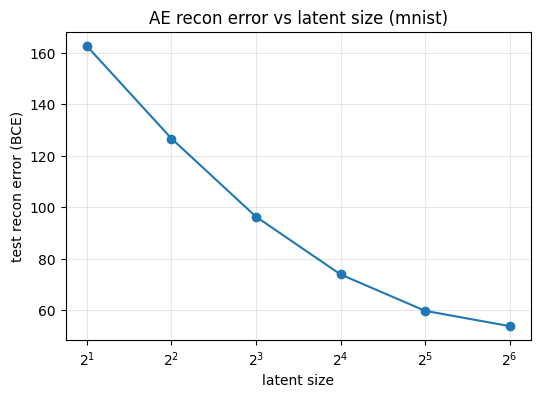

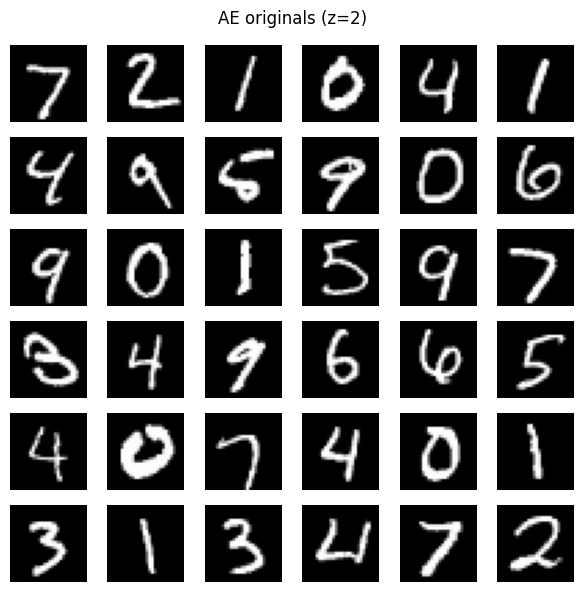

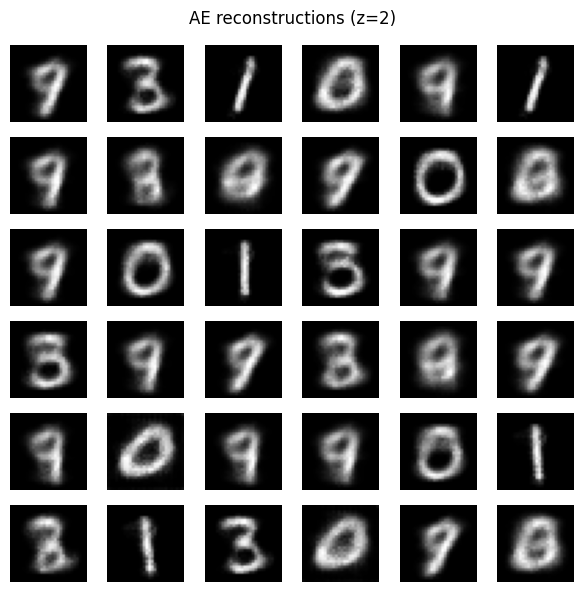

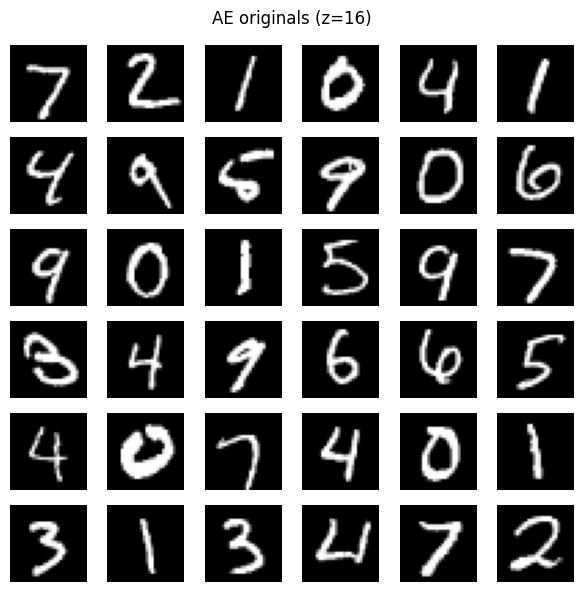

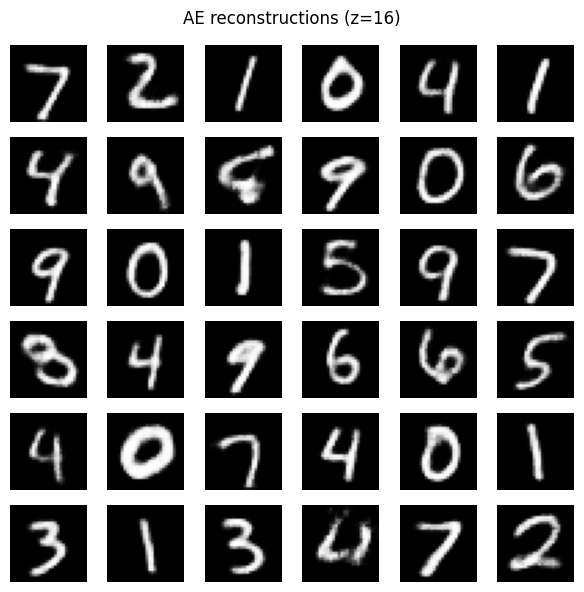

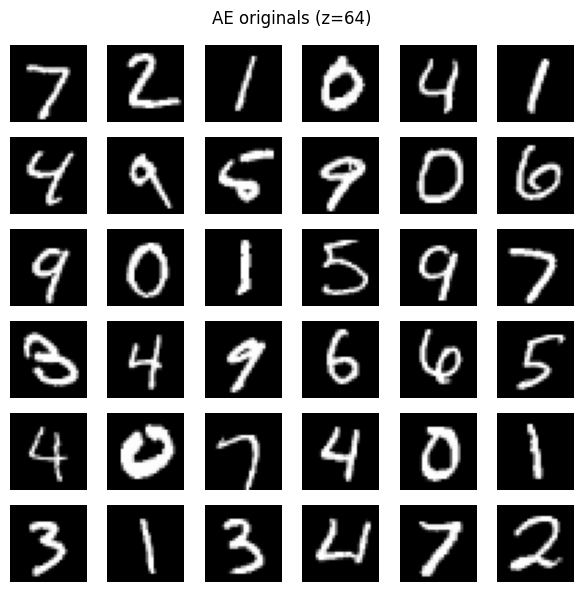

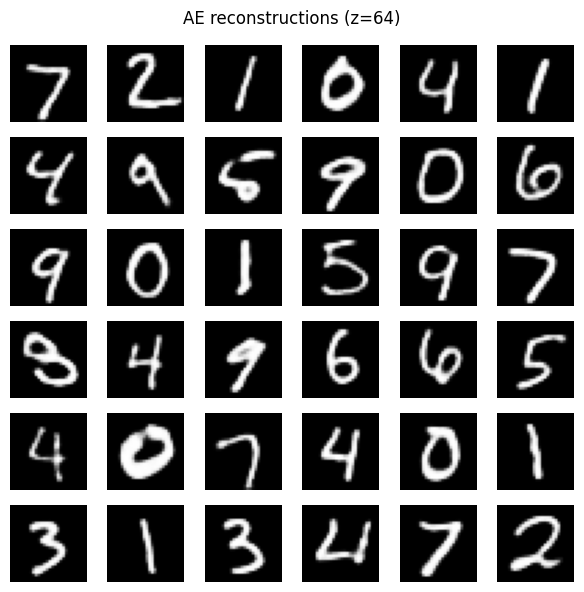

({2: 162.60848637695312,
  4: 126.7450487915039,
  8: 96.37854851074219,
  16: 73.97777852783203,
  32: 59.84806306152344,
  64: 53.90921536865234},
 {2: ConvAE(
    (enc): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (enc_fc): Linear(in_features=3136, out_features=2, bias=True)
    (dec_fc): Linear(in_features=2, out_features=3136, bias=True)
    (dec): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  ),
  4: ConvAE(
    (enc): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (enc_fc): Linear(in_features=3

In [25]:
# AE compression (MNIST)
DATASET_NAME = "mnist"
train_loader, val_loader, test_loader = get_dataloaders("mnist", BATCH_SIZE)
ae_latent_sweep(latent_sizes=(2,4,8,16,32,64), epochs=6)

/tmp/ipython-input-2444664355.py:26: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_recon += float(recon) * bs


[mnist] ep 01  train_bpd=0.367 val_bpd=0.276  (rec=137.3, kl=12.48)
[mnist] ep 02  train_bpd=0.253 val_bpd=0.236  (rec=112.6, kl=15.52)
[mnist] ep 03  train_bpd=0.226 val_bpd=0.220  (rec=102.9, kl=16.70)
[mnist] ep 04  train_bpd=0.213 val_bpd=0.209  (rec=95.5, kl=18.15)
[mnist] ep 05  train_bpd=0.205 val_bpd=0.205  (rec=92.7, kl=18.74)


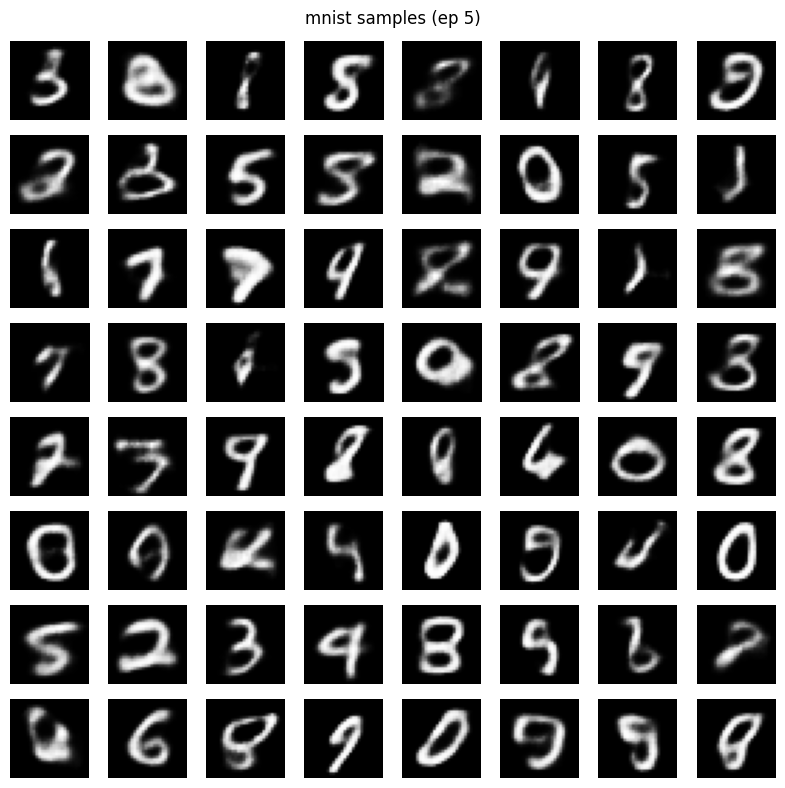

[mnist] ep 06  train_bpd=0.201 val_bpd=0.199  (rec=88.9, kl=19.37)
[mnist] ep 07  train_bpd=0.197 val_bpd=0.197  (rec=87.5, kl=19.78)
[mnist] ep 08  train_bpd=0.194 val_bpd=0.194  (rec=86.1, kl=19.56)
[mnist] ep 09  train_bpd=0.192 val_bpd=0.192  (rec=84.3, kl=20.27)
[mnist] ep 10  train_bpd=0.191 val_bpd=0.191  (rec=83.4, kl=20.36)


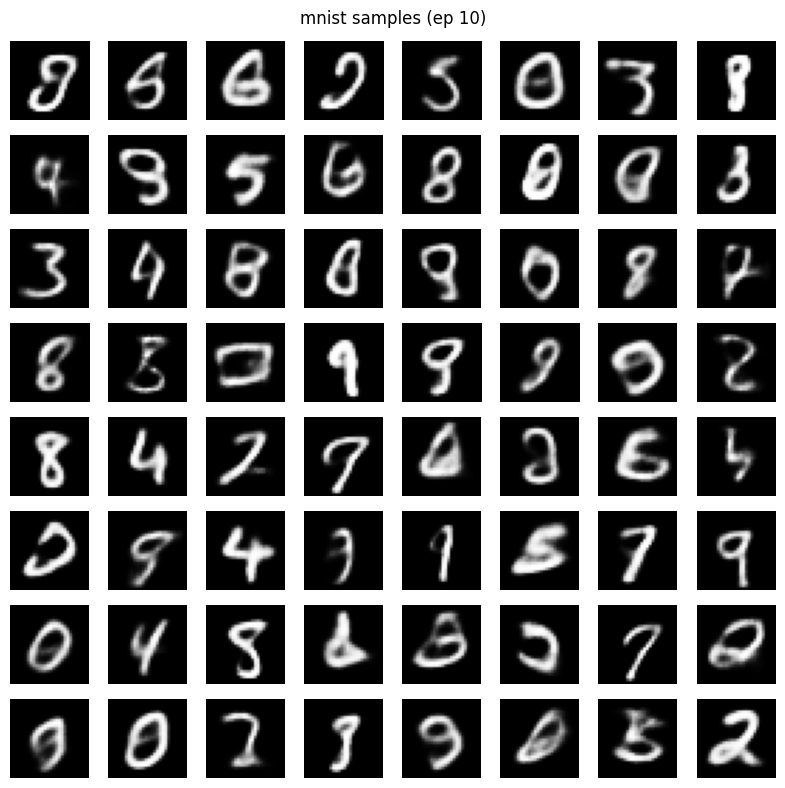

[mnist] ep 11  train_bpd=0.190 val_bpd=0.190  (rec=83.0, kl=20.39)
[mnist] ep 12  train_bpd=0.189 val_bpd=0.189  (rec=82.4, kl=20.27)
[mnist] ep 13  train_bpd=0.188 val_bpd=0.188  (rec=81.8, kl=20.42)
[mnist] ep 14  train_bpd=0.187 val_bpd=0.187  (rec=81.1, kl=20.62)
[mnist] ep 15  train_bpd=0.186 val_bpd=0.187  (rec=80.6, kl=20.91)


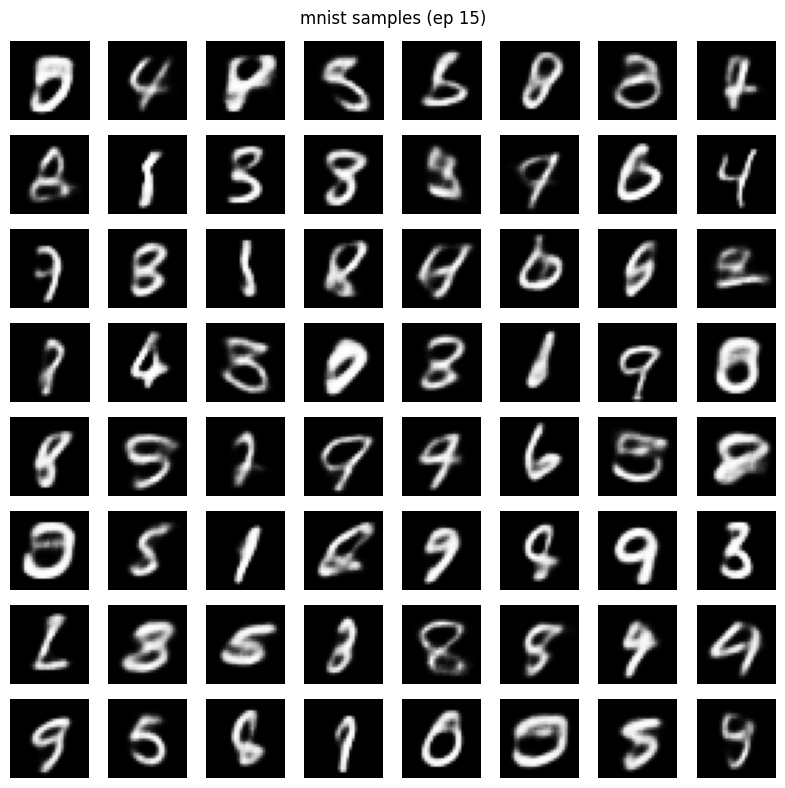

[mnist] ep 16  train_bpd=0.185 val_bpd=0.187  (rec=80.5, kl=20.96)
[mnist] ep 17  train_bpd=0.185 val_bpd=0.186  (rec=81.1, kl=19.97)
[mnist] ep 18  train_bpd=0.184 val_bpd=0.185  (rec=79.7, kl=20.94)
[mnist] ep 19  train_bpd=0.184 val_bpd=0.185  (rec=79.4, kl=21.06)
[mnist] ep 20  train_bpd=0.183 val_bpd=0.185  (rec=79.8, kl=20.58)


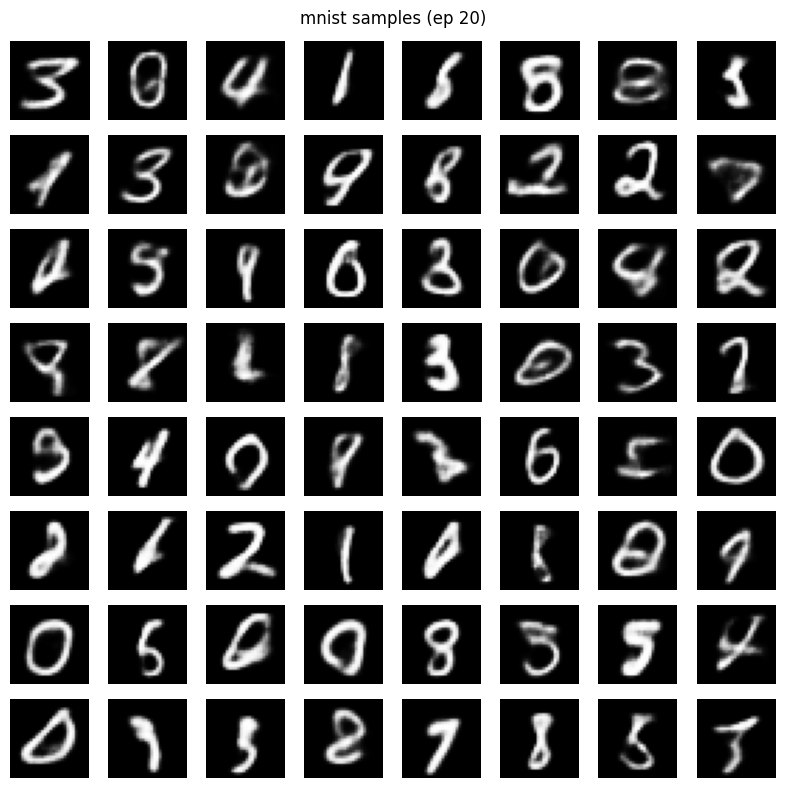

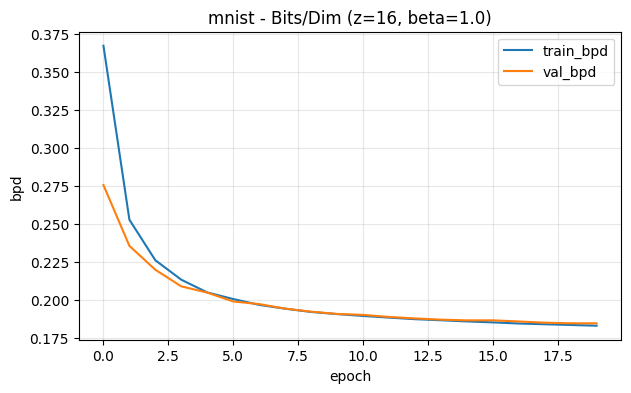

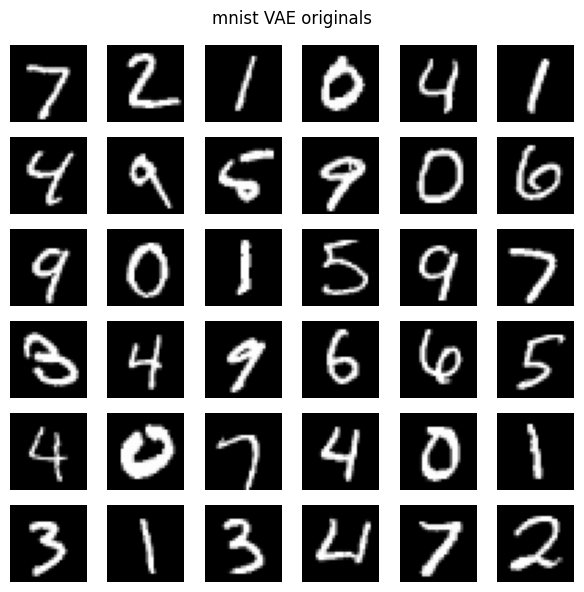

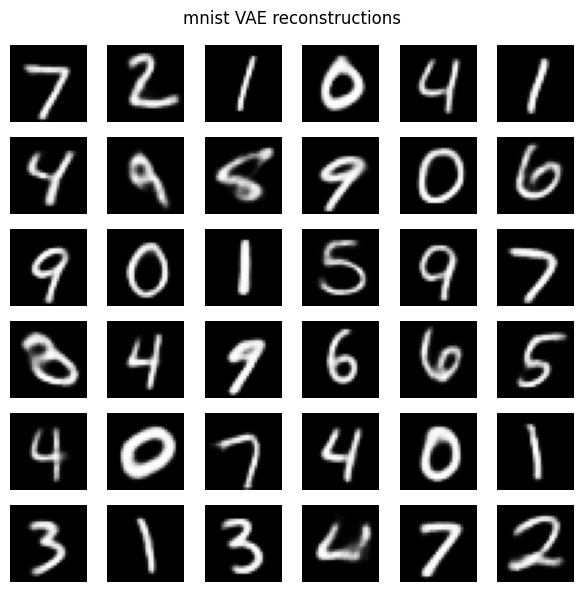

TEST [mnist] nll=99.76 bpd=0.184 recon=79.2 kl=20.57


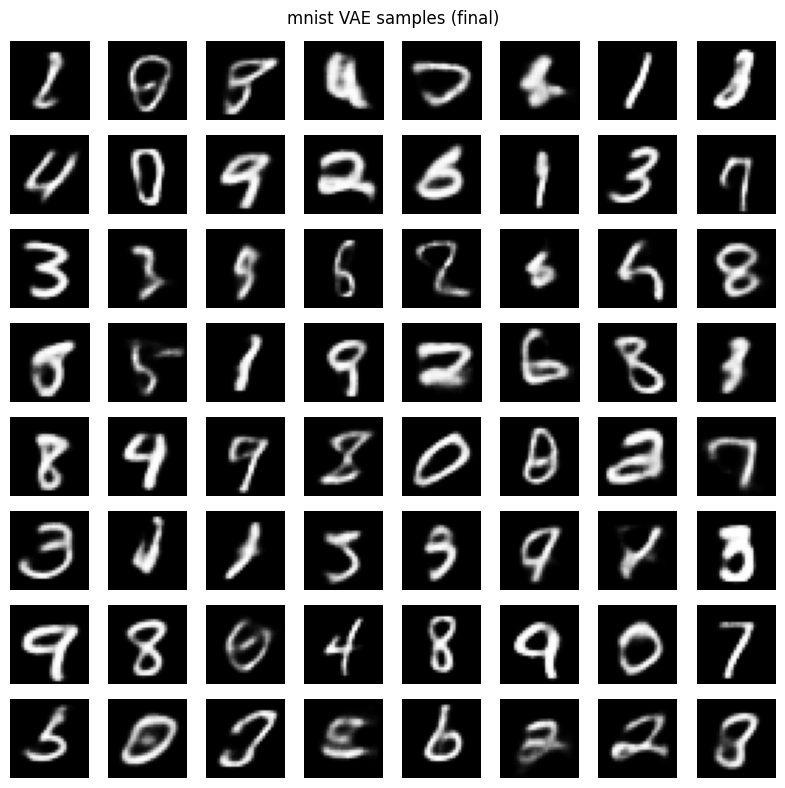

In [17]:
vae_mnist, _ = run_vae("mnist", z_dim=16, epochs=20, beta=1.0)

In [19]:
from torchvision import datasets as tv_datasets, transforms
from torch.utils.data import DataLoader, random_split

In [20]:
def get_dataloaders(name="mnist", batch_size=256, val_ratio=0.1):
    name = name.lower()
    ds_train = tv_datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
    ds_test  = tv_datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

    n_val = int(len(ds_train) * val_ratio)
    n_tr  = len(ds_train) - n_val
    ds_tr, ds_val = random_split(ds_train, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

    tr_loader  = DataLoader(ds_tr,  batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    te_loader  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return tr_loader, val_loader, te_loader

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]


AE sweep z_dim=2 on mnist


  ep 01 train=319.9926 val=285.3924
  ep 02 train=279.5008 val=278.0167
  ep 03 train=274.0701 val=273.9960
  ep 04 train=270.9236 val=271.0304
  ep 05 train=268.3983 val=268.5694
  ep 06 train=266.3328 val=266.8530
test recon=266.8856

AE sweep z_dim=4 on mnist
  ep 01 train=291.5660 val=253.8876
  ep 02 train=249.0505 val=247.6776
  ep 03 train=245.2357 val=245.1370
  ep 04 train=242.8653 val=242.9813
  ep 05 train=241.2009 val=241.5816
  ep 06 train=240.0889 val=240.9077
test recon=241.6411

AE sweep z_dim=8 on mnist
  ep 01 train=285.1116 val=243.2521
  ep 02 train=238.1654 val=236.2398
  ep 03 train=233.5163 val=233.2885
  ep 04 train=231.0499 val=231.1746
  ep 05 train=229.4893 val=230.3316
  ep 06 train=228.3291 val=228.9054
test recon=229.6329

AE sweep z_dim=16 on mnist
  ep 01 train=279.8910 val=237.3787
  ep 02 train=230.3974 val=227.3823
  ep 03 train=224.6598 val=223.8116
  ep 04 train=221.9497 val=221.8202
  ep 05 train=220.3135 val=220.5068
  ep 06 train=219.0959 val=219

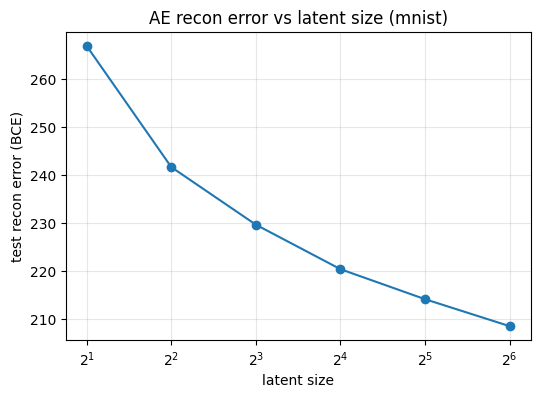

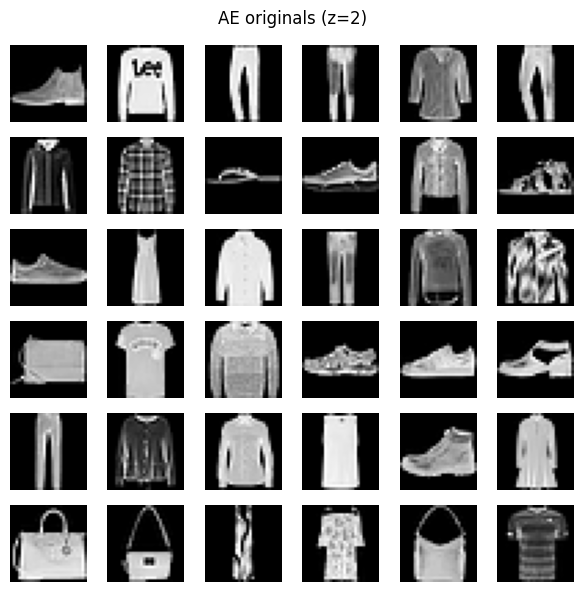

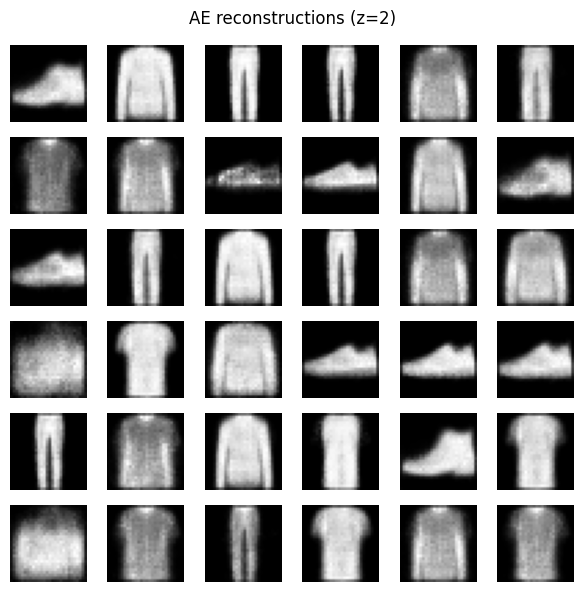

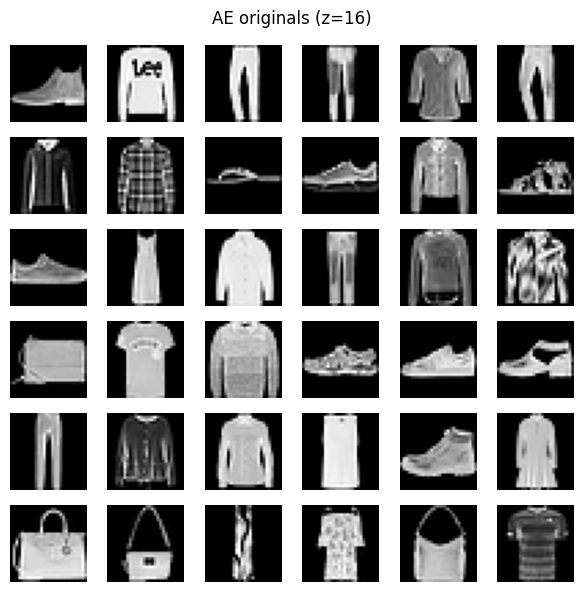

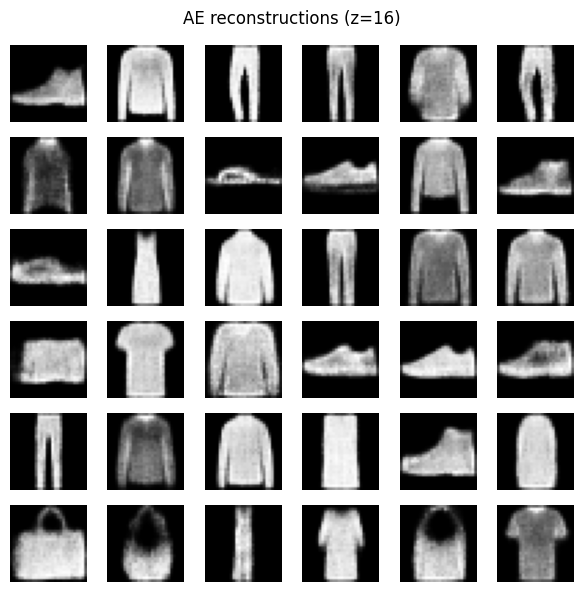

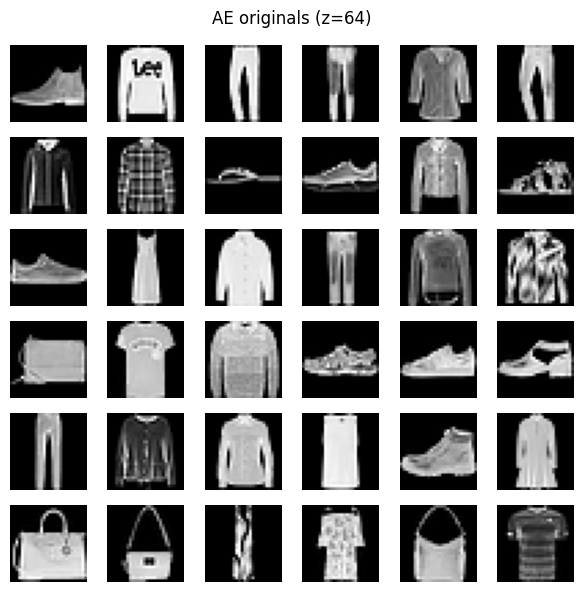

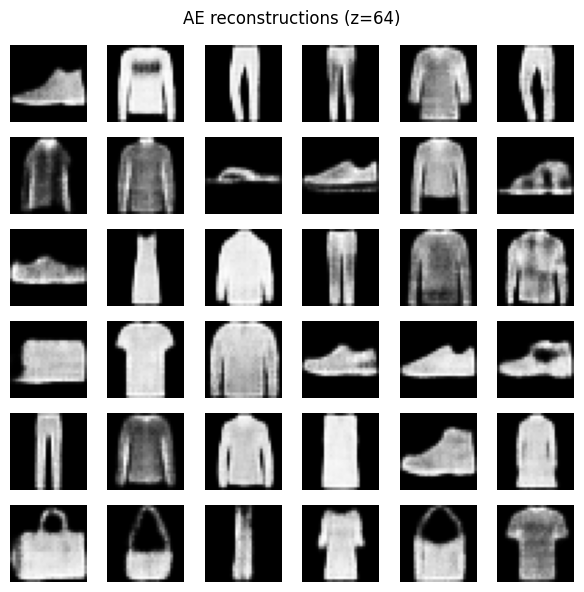

({2: 266.88563984375,
  4: 241.64112397460937,
  8: 229.63289340820313,
  16: 220.35401398925782,
  32: 214.0956364013672,
  64: 208.47280151367187},
 {2: ConvAE(
    (enc): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (enc_fc): Linear(in_features=3136, out_features=2, bias=True)
    (dec_fc): Linear(in_features=2, out_features=3136, bias=True)
    (dec): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  ),
  4: ConvAE(
    (enc): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (enc_fc): Linear(in_features=

In [21]:
train_loader, val_loader, test_loader = get_dataloaders("fashion", BATCH_SIZE)
ae_latent_sweep(latent_sizes=(2,4,8,16,32,64), epochs=6)

[fashionmnist] ep 01  train_bpd=0.574 val_bpd=0.495  (rec=256.7, kl=12.45)
[fashionmnist] ep 02  train_bpd=0.482 val_bpd=0.475  (rec=245.4, kl=12.88)
[fashionmnist] ep 03  train_bpd=0.469 val_bpd=0.466  (rec=240.5, kl=12.46)
[fashionmnist] ep 04  train_bpd=0.461 val_bpd=0.460  (rec=237.5, kl=12.66)
[fashionmnist] ep 05  train_bpd=0.457 val_bpd=0.457  (rec=235.6, kl=12.47)


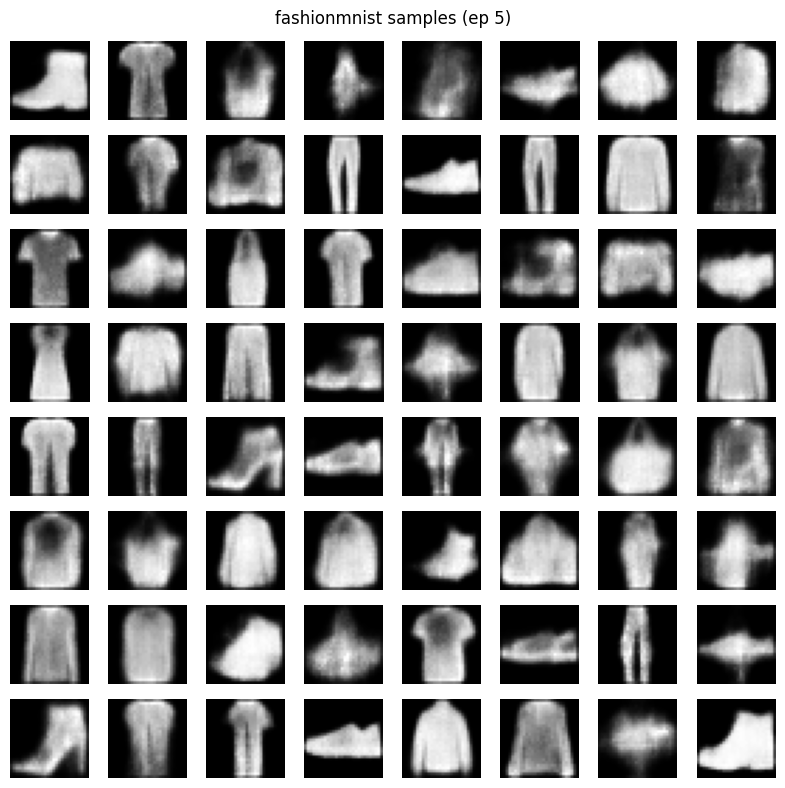

[fashionmnist] ep 06  train_bpd=0.453 val_bpd=0.454  (rec=233.6, kl=13.01)
[fashionmnist] ep 07  train_bpd=0.451 val_bpd=0.453  (rec=233.3, kl=12.86)
[fashionmnist] ep 08  train_bpd=0.449 val_bpd=0.450  (rec=231.3, kl=13.00)
[fashionmnist] ep 09  train_bpd=0.447 val_bpd=0.449  (rec=231.3, kl=12.68)
[fashionmnist] ep 10  train_bpd=0.446 val_bpd=0.448  (rec=230.4, kl=13.02)


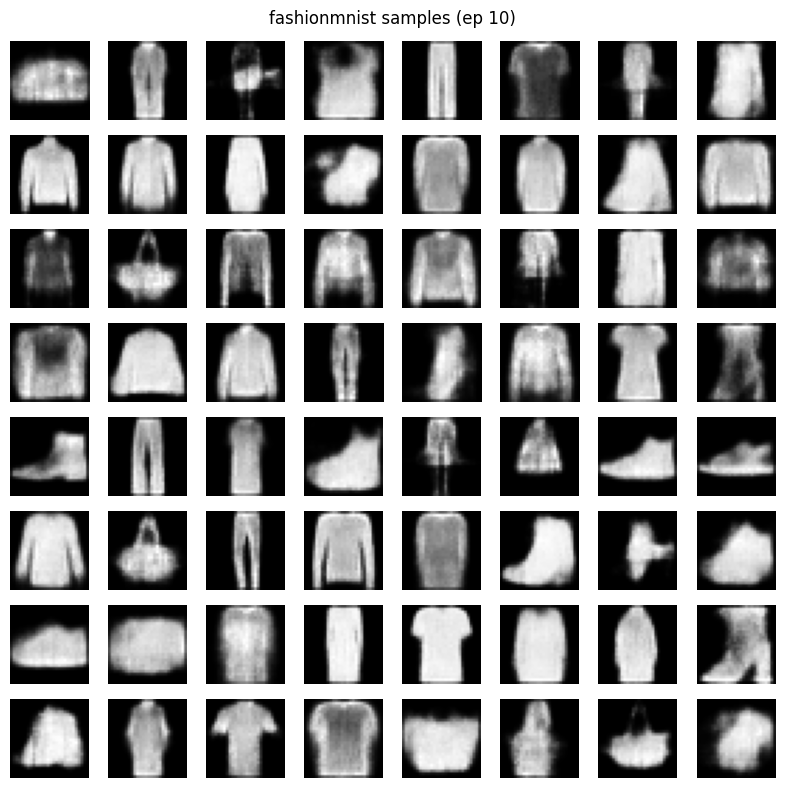

[fashionmnist] ep 11  train_bpd=0.445 val_bpd=0.449  (rec=231.0, kl=12.87)
[fashionmnist] ep 12  train_bpd=0.444 val_bpd=0.446  (rec=229.6, kl=12.96)
[fashionmnist] ep 13  train_bpd=0.443 val_bpd=0.445  (rec=228.5, kl=13.22)
[fashionmnist] ep 14  train_bpd=0.442 val_bpd=0.444  (rec=227.8, kl=13.24)
[fashionmnist] ep 15  train_bpd=0.442 val_bpd=0.443  (rec=227.7, kl=13.07)


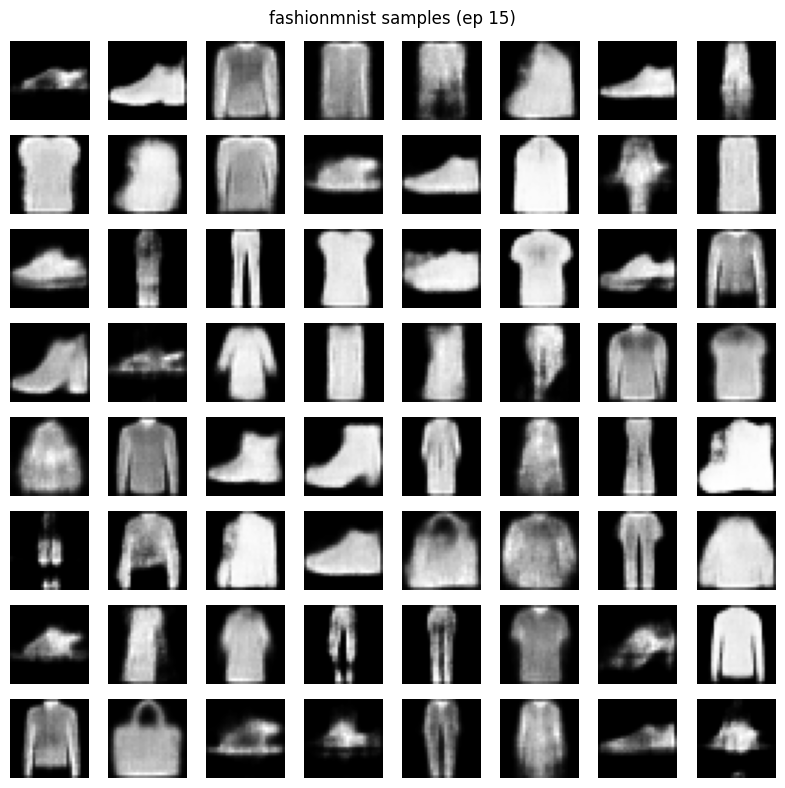

[fashionmnist] ep 16  train_bpd=0.441 val_bpd=0.443  (rec=227.3, kl=13.34)
[fashionmnist] ep 17  train_bpd=0.441 val_bpd=0.443  (rec=227.5, kl=13.11)
[fashionmnist] ep 18  train_bpd=0.440 val_bpd=0.442  (rec=226.8, kl=13.45)
[fashionmnist] ep 19  train_bpd=0.440 val_bpd=0.444  (rec=227.7, kl=13.29)
[fashionmnist] ep 20  train_bpd=0.439 val_bpd=0.441  (rec=226.6, kl=13.23)


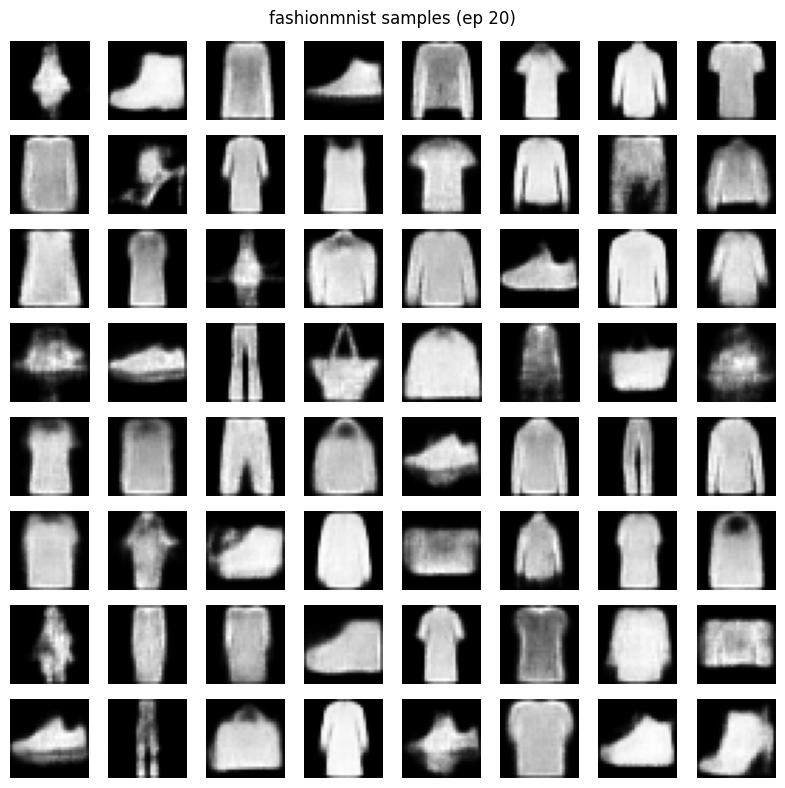

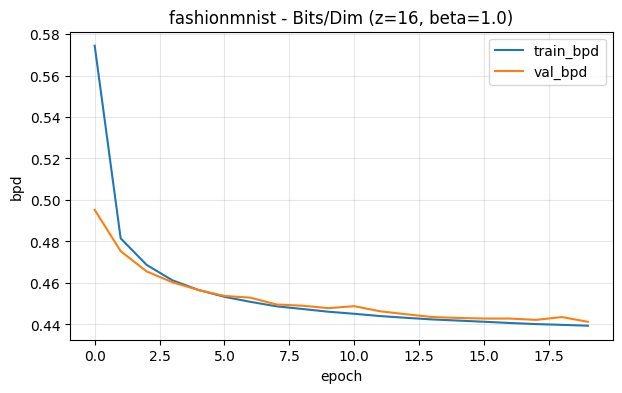

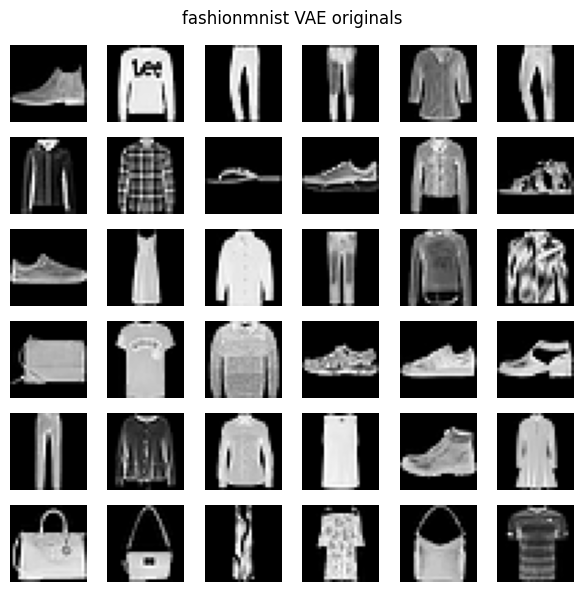

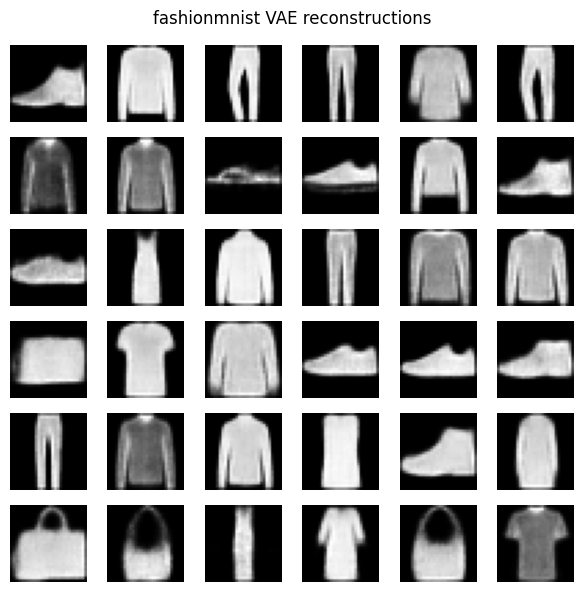

TEST [fashionmnist] nll=240.56 bpd=0.443 recon=227.4 kl=13.17


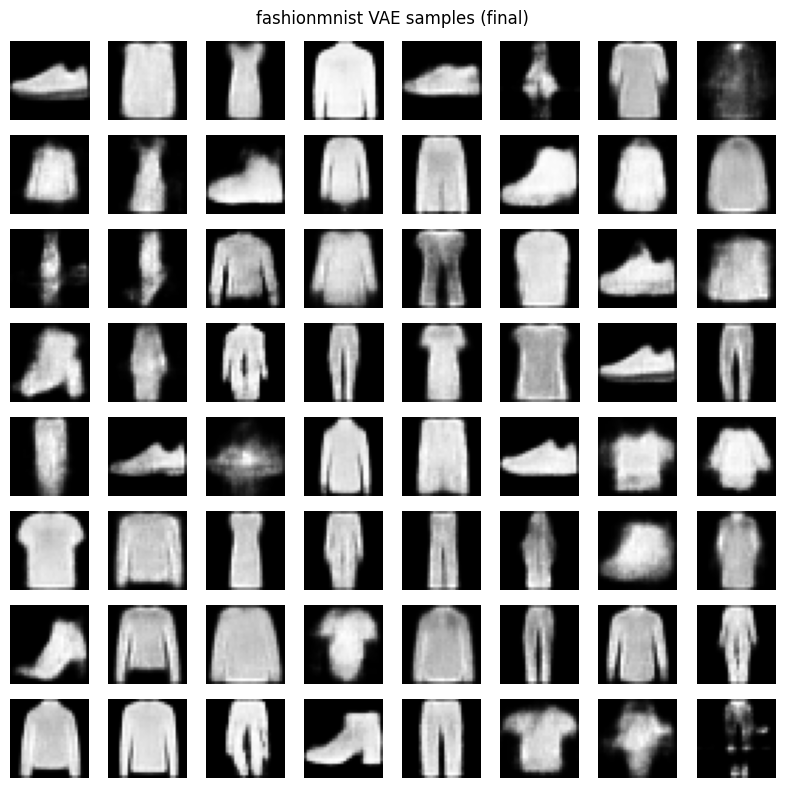

In [22]:
vae_fmnist, _ = run_vae("fashionmnist", z_dim=16, epochs=20, beta=1.0)

[mnist] ep 01  train_bpd=0.383 val_bpd=0.327  (rec=160.7, kl=4.24)
[mnist] ep 02  train_bpd=0.310 val_bpd=0.299  (rec=138.6, kl=6.02)
[mnist] ep 03  train_bpd=0.293 val_bpd=0.289  (rec=129.8, kl=6.74)
[mnist] ep 04  train_bpd=0.285 val_bpd=0.282  (rec=124.0, kl=7.36)
[mnist] ep 05  train_bpd=0.280 val_bpd=0.278  (rec=119.9, kl=7.84)


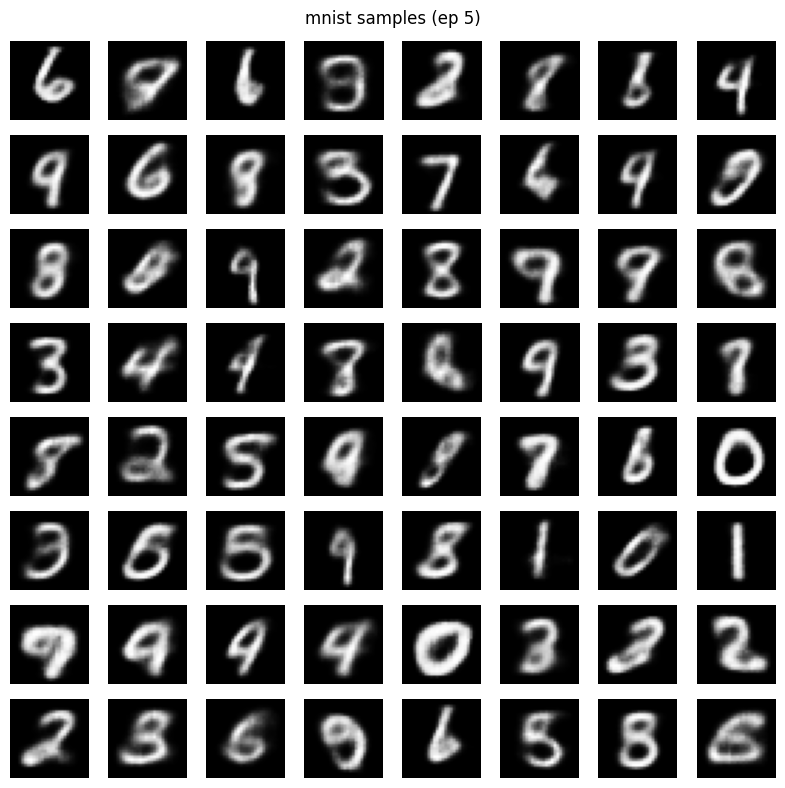

[mnist] ep 06  train_bpd=0.277 val_bpd=0.276  (rec=116.7, kl=8.31)
[mnist] ep 07  train_bpd=0.274 val_bpd=0.274  (rec=113.8, kl=8.76)
[mnist] ep 08  train_bpd=0.272 val_bpd=0.272  (rec=112.1, kl=8.96)
[mnist] ep 09  train_bpd=0.271 val_bpd=0.272  (rec=112.6, kl=8.82)
[mnist] ep 10  train_bpd=0.270 val_bpd=0.270  (rec=112.3, kl=8.55)


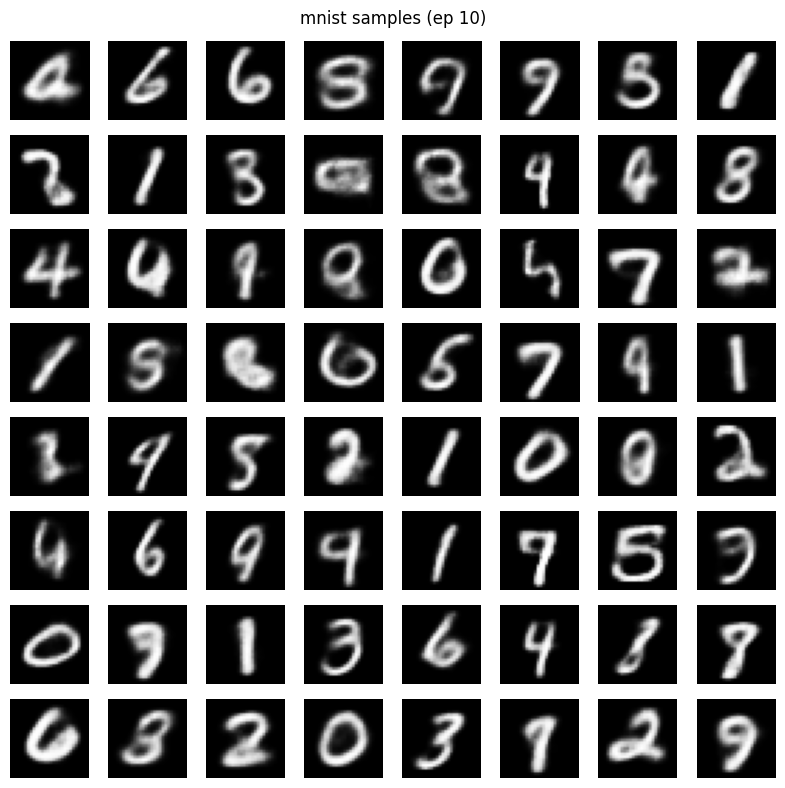

[mnist] ep 11  train_bpd=0.269 val_bpd=0.269  (rec=111.5, kl=8.68)
[mnist] ep 12  train_bpd=0.268 val_bpd=0.269  (rec=111.9, kl=8.51)
[mnist] ep 13  train_bpd=0.267 val_bpd=0.267  (rec=108.8, kl=9.13)
[mnist] ep 14  train_bpd=0.266 val_bpd=0.267  (rec=109.2, kl=9.02)
[mnist] ep 15  train_bpd=0.266 val_bpd=0.267  (rec=109.5, kl=8.88)


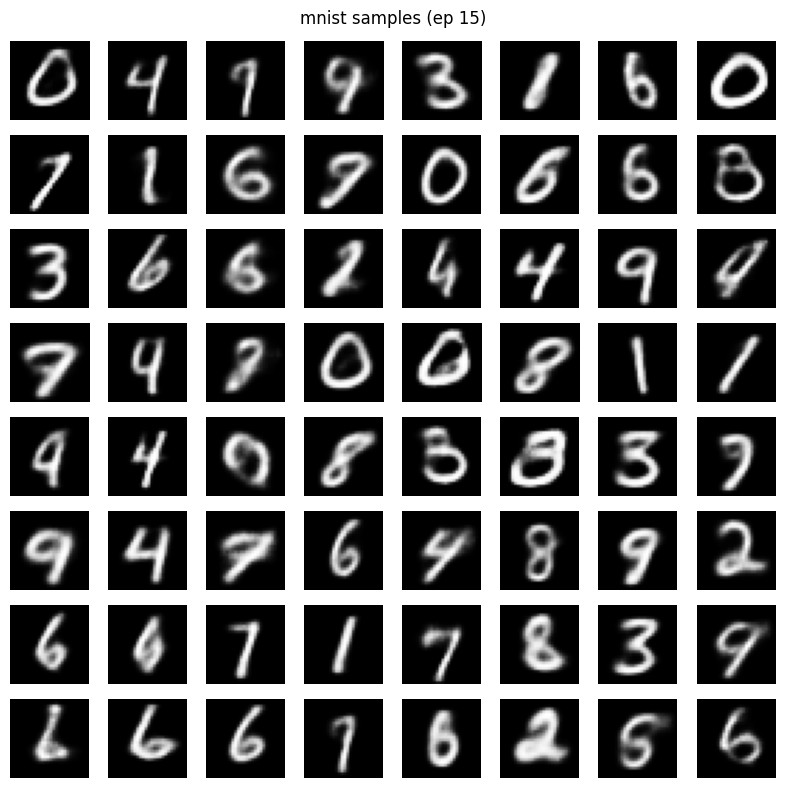

[mnist] ep 16  train_bpd=0.265 val_bpd=0.265  (rec=108.2, kl=8.99)
[mnist] ep 17  train_bpd=0.265 val_bpd=0.265  (rec=108.1, kl=9.03)
[mnist] ep 18  train_bpd=0.264 val_bpd=0.265  (rec=107.4, kl=9.13)
[mnist] ep 19  train_bpd=0.263 val_bpd=0.265  (rec=107.3, kl=9.16)
[mnist] ep 20  train_bpd=0.263 val_bpd=0.265  (rec=106.7, kl=9.27)


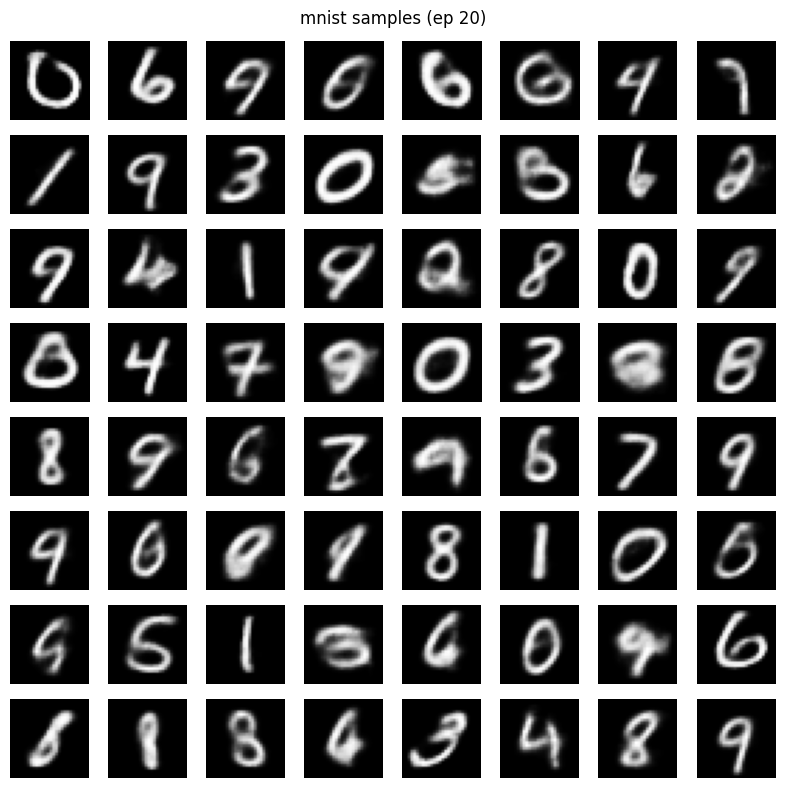

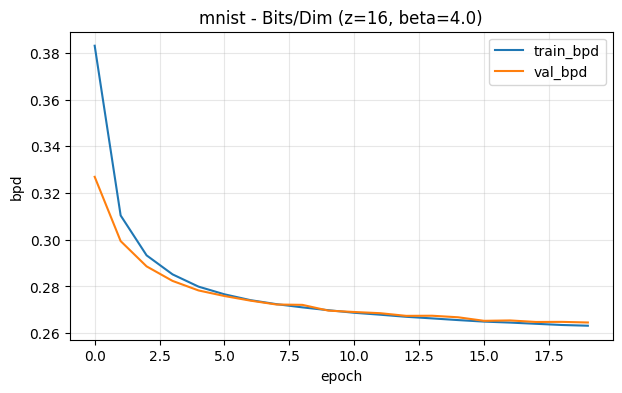

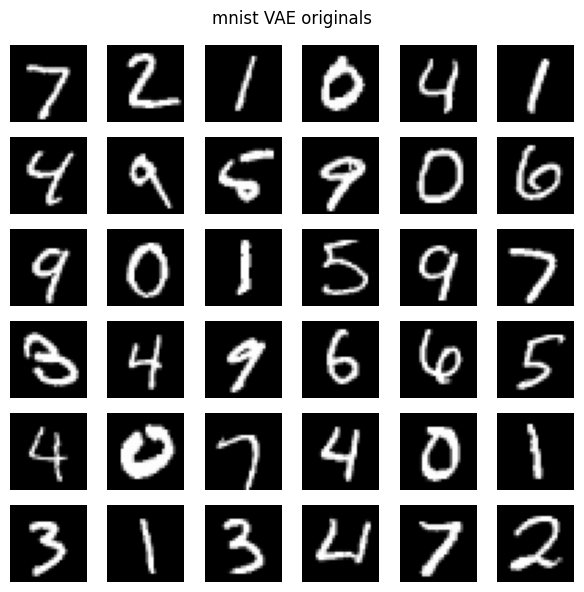

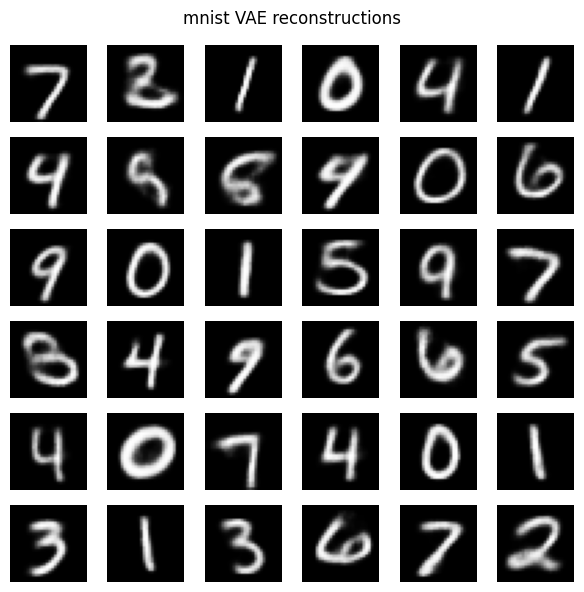

TEST [mnist] nll=142.98 bpd=0.263 recon=105.9 kl=9.28


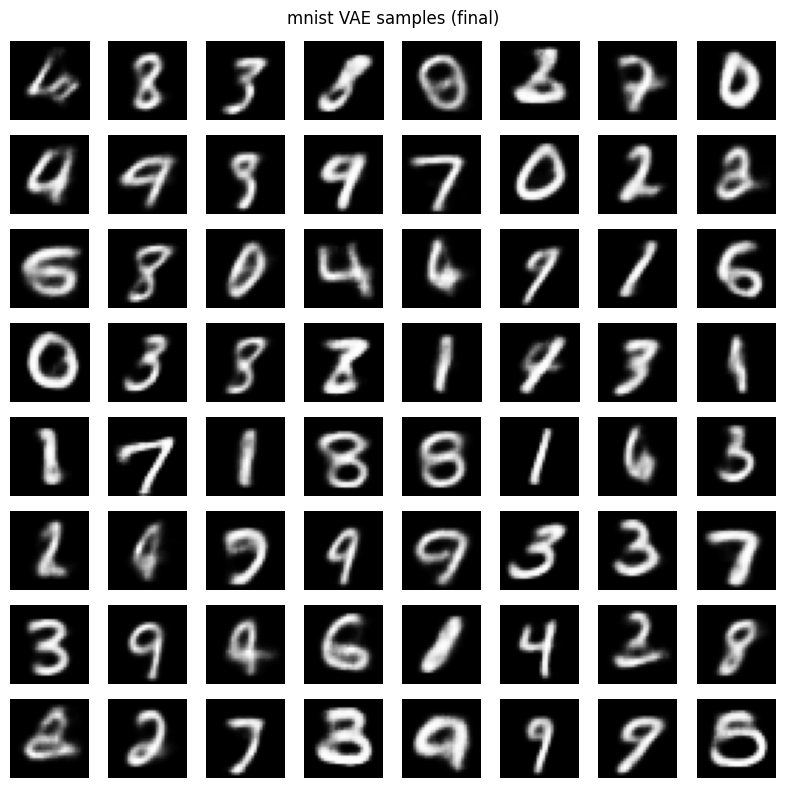

In [26]:
vae_mnist_beta, _ = run_vae("mnist", z_dim=16, epochs=20, beta=4.0)